# Predicting Disease Associate Genes Relationship (Part 2)

This notebook is designed to analyze the discriminator models used for this project. Based on the power of weak supervision, we now have access to deep learning models such as long short term memory networks (LSTM) or convolutional neural networks (CNN). This is exciting because, previous research studies have shown great success using these models; however, a significant caveat is that these classifiers are difficult to train. Usually they will overfit to the training dataset, which leads towards poor performance on the classification task.

## Set Up the Environment

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


from collections import OrderedDict
import glob
import os
import pickle
import re
import sys

sys.path.append(os.path.abspath('../../../modules'))
sys.path.append(os.path.abspath('../'))

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

import torch
import torch.nn as nn

In [2]:
#Set up the environment
username = "danich1"
password = "snorkel"
dbname = "pubmeddb"

#Path subject to change for different os
database_str = "postgresql+psycopg2://{}:{}@/{}?host=/var/run/postgresql".format(username, password, dbname)
os.environ['SNORKELDB'] = database_str

from snorkel import SnorkelSession
session = SnorkelSession()

In [3]:
from snorkel.models import Candidate, candidate_subclass
from cnn import PaddedEmbeddings, CNN
from metal.modules import LSTMModule
from metal.modules.lstm_module import EmbeddingsEncoder
from metal.end_model import EndModel

from utils.notebook_utils.label_matrix_helper import label_candidates, get_auc_significant_stats
from utils.notebook_utils.dataframe_helper import load_candidate_dataframes
from utils.notebook_utils.plot_helper import plot_curve, plot_label_matrix_heatmap
from utils.notebook_utils.train_model_helper import get_attn_scores, get_network_results

In [4]:
DiseaseGene = candidate_subclass('DiseaseGene', ['Disease', 'Gene'])

In [5]:
spreadsheet_names = {
    #'train': 'multitask_experiment/data/sentences/sentence_labels_train.xlsx',
    'dev': 'data/sentences/sentence_labels_dev.xlsx',
    'test': 'data/sentences/sentence_labels_test.xlsx',
}

In [6]:
candidate_dfs = {
    key:load_candidate_dataframes(spreadsheet_names[key])
    for key in spreadsheet_names
}

for key in candidate_dfs:
    print("Size of {} set: {}".format(key, candidate_dfs[key].shape[0]))

Size of dev set: 1000
Size of test set: 1000


In [7]:
dg_map_df = pd.read_table("../dataset_statistics/all_dg_candidates_map.tsv.xz")
dg_map_df.head(2)

,entrez_gene_id,gene_symbol,doid_id,doid_name,sources,hetionet,n_sentences,has_sentence,partition_rank,split,compound_mention_count,disease_mention_count,gene_mention_count,sentence_id,text,sen_length,candidate_id
0,1,A1BG,DOID:2531,hematologic cancer,NaN,0,8,1,0.8586,1,0.0,1.0,3.0,2129459,The number of H antigen sites per single red c...,172,176680
1,1,A1BG,DOID:2531,hematologic cancer,NaN,0,8,1,0.8586,1,0.0,1.0,3.0,2129459,The number of H antigen sites per single red c...,172,176675


In [8]:
dev_data = pd.read_table("data/dev_dataframe.tsv.xz").sort_values("candidate_id")
dev_data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,184,185,186,187,188,189,190,191,candidate_id,sen_length
0,9,529,2,2963,72,26,9,14475,436,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21841,63
1,15,36,21,2051,10,8,1,12,394,32771,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,82680,72


In [9]:
test_data = pd.read_table("data/test_dataframe.tsv.xz").sort_values("candidate_id")
test_data.head(2)

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,candidate_id,sen_length
0,3914,192,8,15,10719,10,7465,1016,142,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23356,50
1,9,584,20,3,22521,4,28,66,94,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23367,22


In [10]:
word_vectors = pd.read_table(
    "data/training_word_vectors.bin", 
    sep=" ", skiprows=1,
    header=None,index_col=0, 
    keep_default_na=False
)
word_vectors.head(2)

,1,2,3,4,5,6,7,8,9,10,...,291,292,293,294,295,296,297,298,299,300
0,,,,,,,,,,,,,,,,,,,,,
of,-0.011309,-0.086732,-0.048526,0.014612,-0.045023,-0.220397,-0.242358,0.060525,0.167045,-0.288198,...,0.000426,-0.005404,-0.021657,-0.102170,0.200634,0.187765,0.025791,-0.044495,-0.034465,-0.031029
~~[[2,-0.179990,0.167300,-0.507239,0.111690,-0.269776,-0.256630,0.207848,-0.187613,0.456848,-0.358285,...,0.285407,0.042137,0.371122,-0.173622,-0.534416,0.248068,-0.239652,-0.370680,-0.199664,-0.010923


In [11]:
cutoff = 60

In [12]:
dev_X = torch.LongTensor(
    dev_data
    .query("sen_length < @cutoff")
    [[col for col in dev_data.columns if col in list(map(lambda x: str(x),range(cutoff-1)))]]
    .fillna(0)
    .values
)
dev_Y = torch.LongTensor(
    dev_data
    .query("sen_length < @cutoff")
    .merge(candidate_dfs['dev'])
    .curated_dsh
    .apply(lambda x: 1 if x > 0 else 2)
    .values
)

test_X = torch.LongTensor(
    test_data
    .query("sen_length < @cutoff")
    [[col for col in test_data.columns if col in list(map(lambda x: str(x),range(cutoff-1)))]]
    .fillna(0)
    .values
)
test_Y = torch.LongTensor(
    test_data
    .query("sen_length < @cutoff")
    .merge(candidate_dfs['test'])
    .curated_dsh
    .apply(lambda x: 1 if x > 0 else 2)
    .values
)

In [13]:
gen_model_dev_df = (
    pd.read_table("data/gen_model_dev_set_pred.tsv")
    .merge(dev_data.query("sen_length < @cutoff"), on="candidate_id")
    .sort_values("candidate_id")
)
gen_model_test_df = (
    pd.read_table("data/gen_model_test_set_pred.tsv")
    .merge(test_data.query("sen_length < @cutoff"), on="candidate_id")
    .sort_values("candidate_id")
)

# LSTM Network Evaluation

Used a LSTM network with an attention layer at the end. The following parameters for the network are produced below in the table:

| Parameter | Network 1 | Network 2 | Network 3 | Network 4 | Network 5 | Network 6 |
|-------|-------|-------|-------|-------|-------|-------|
| Word Embeddings | 300 dim (fixed) | 300 dim (fixed) | 300 dim (fixed) | 300 dim (fixed) | 300 dim (free) | 300 dim (free) | 
| Hidden State | 50 Dim |  100 Dim | 250 Dim | 300 Dim | 250 Dim | 250 Dim |
| Dropout | 0.25 (outside) and 0.25 (inside) | 0.25 (outside) and 0.25 (inside) | 0.25 (outside) and 0.25 (inside) | 0.25 (outside) and 0.25 (inside) | 0.25 (outside) and 0.25 (inside) | 0.25 (outside) and 0.25 (inside) |
| Layers | 2 | 2 | 2 | 2 | 2 | 2 |
| learning rate | 0.01 |  0.01 |  0.01 |  0.01 | 0.01 | 0.01 | 
| optimizer | adam with betas (0.9, 0.99) | adam with betas (0.9, 0.99) | adam with betas (0.9, 0.99) | adam with betas (0.9, 0.99) | adam with betas (0.9, 0.99) | adam with betas (0.9, 0.99) |
| Batch Size | 256 | 256 | 256 | 256 | 256 | 64 | 
    

In [40]:
lstm_params = {
    "LSTM Network 1":
    {
        "hidden_size":50,
        "output_size":2,
        "seed":100,
        "word_embeddings":300,
        "vocab_size":word_vectors.shape[0]+2,
        "max_dim": 59,
        "output_size": 2,
        "num_layers": 2,
        "freeze_embeddings":True,
        "outside_dropout":0.25,
        "inside_dropout": 0.25,
    },
    "LSTM Network 2":
    {
        "hidden_size":100,
        "output_size":2,
        "seed":100,
        "word_embeddings":300,
        "vocab_size":word_vectors.shape[0]+2,
        "max_dim": 59,
        "output_size": 2,
        "num_layers": 2,
        "freeze_embeddings":True,
        "outside_dropout":0.25,
        "inside_dropout": 0.25,
    },
    "LSTM Network 3":
    {
        "hidden_size":250,
        "output_size":2,
        "seed":100,
        "word_embeddings":300,
        "vocab_size":word_vectors.shape[0]+2,
        "max_dim": 59,
        "output_size": 2,
        "num_layers": 2,
        "freeze_embeddings":True,
        "outside_dropout":0.25,
        "inside_dropout": 0.25,
    },
    "LSTM Network 4":
    {
        "hidden_size":300,
        "output_size":2,
        "seed":100,
        "word_embeddings":300,
        "vocab_size":word_vectors.shape[0]+2,
        "max_dim": 59,
        "output_size": 2,
        "num_layers": 2,
        "freeze_embeddings":True,
        "outside_dropout":0.25,
        "inside_dropout": 0.25,
    },
    "LSTM Network 5":
    {
        "hidden_size":250,
        "output_size":2,
        "seed":100,
        "word_embeddings":300,
        "vocab_size":word_vectors.shape[0]+2,
        "max_dim": 59,
        "output_size": 2,
        "num_layers": 2,
        "freeze_embeddings":True,
        "outside_dropout":0.25,
        "inside_dropout": 0.25,
        "l2":0.01
    },
    "LSTM Network 6":
    {
        "hidden_size":250,
        "output_size":2,
        "seed":100,
        "word_embeddings":300,
        "vocab_size":word_vectors.shape[0]+2,
        "max_dim": 59,
        "output_size": 2,
        "num_layers": 2,
        "freeze_embeddings":True,
        "outside_dropout":0.25,
        "inside_dropout": 0.25,
        "l2":0.1
    },
    "LSTM Network 7":
    {
        "hidden_size":250,
        "output_size":2,
        "seed":100,
        "word_embeddings":300,
        "vocab_size":word_vectors.shape[0]+2,
        "max_dim": 59,
        "output_size": 2,
        "num_layers": 2,
        "freeze_embeddings":True,
        "outside_dropout":0.25,
        "inside_dropout": 0.25,
        "l2":0.25
    },
    "LSTM Network 8":
    {
        "hidden_size":250,
        "output_size":2,
        "seed":100,
        "word_embeddings":300,
        "vocab_size":word_vectors.shape[0]+2,
        "max_dim": 59,
        "output_size": 2,
        "num_layers": 2,
        "freeze_embeddings":True,
        "outside_dropout":0.25,
        "inside_dropout": 0.25,
        "l2":0.35,
        "batch_norm":False,
    },
    "LSTM Network 9":
    {
        "hidden_size":250,
        "output_size":2,
        "seed":100,
        "word_embeddings":300,
        "vocab_size":word_vectors.shape[0]+2,
        "max_dim": 59,
        "output_size": 2,
        "num_layers": 2,
        "freeze_embeddings":True,
        "outside_dropout":0.25,
        "inside_dropout": 0.25,
        "l2":0.45,
        "batch_norm":False,
    },
    "LSTM Network 10":
    {
        "hidden_size":250,
        "output_size":2,
        "seed":100,
        "word_embeddings":300,
        "vocab_size":word_vectors.shape[0]+2,
        "max_dim": 59,
        "output_size": 2,
        "num_layers": 2,
        "freeze_embeddings":True,
        "outside_dropout":0.25,
        "inside_dropout": 0.25,
        "l2":0.5
    },
    "LSTM Network 11":
    {
        "hidden_size":250,
        "output_size":2,
        "seed":100,
        "word_embeddings":300,
        "vocab_size":word_vectors.shape[0]+2,
        "max_dim": 59,
        "output_size": 2,
        "num_layers": 2,
        "freeze_embeddings":True,
        "outside_dropout":0.25,
        "inside_dropout": 0.25,
        "l2":0.05,
        "batch_norm":True,
    },
    "LSTM Network 12":
    {
        "hidden_size":250,
        "output_size":2,
        "seed":100,
        "word_embeddings":300,
        "vocab_size":word_vectors.shape[0]+2,
        "max_dim": 59,
        "output_size": 2,
        "num_layers": 2,
        "freeze_embeddings":True,
        "outside_dropout":0.25,
        "inside_dropout": 0.25,
        "l2":0.25,
        "batch_norm":True,
    },

}

In [41]:
lstm_model_paths = {
    "LSTM Network 1":sorted(
            glob.glob("data/final_models/fixed_index/lstm/300_50_frozen_both_dropout_0.25/*checkpoint*"), 
            key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "LSTM Network 2":sorted(
            glob.glob("data/final_models/fixed_index/lstm/300_100_frozen_both_dropout_0.25/*checkpoint*"),
            key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "LSTM Network 3":sorted(
        glob.glob("data/final_models/fixed_index/lstm/300_250_frozen_both_dropout_0.25/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "LSTM Network 4":sorted(
        glob.glob("data/final_models/fixed_index/lstm/300_300_frozen_both_dropout_0.25/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "LSTM Network 5":sorted(
        glob.glob("data/final_models/fixed_index/lstm/300_250_frozen_both_dropout_0.25_l2_0.01/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "LSTM Network 6":sorted(
        glob.glob("data/final_models/fixed_index/lstm/300_250_frozen_both_dropout_0.25_l2_0.1/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "LSTM Network 7":sorted(
        glob.glob("data/final_models/fixed_index/lstm/300_250_frozen_both_dropout_0.25_l2_0.25/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "LSTM Network 8":sorted(
        glob.glob("data/final_models/fixed_index/lstm/300_250_frozen_both_dropout_0.25_l2_0.35/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "LSTM Network 9":sorted(
        glob.glob("data/final_models/fixed_index/lstm/300_250_frozen_both_dropout_0.25_l2_0.45/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "LSTM Network 10":sorted(
        glob.glob("data/final_models/fixed_index/lstm/300_250_frozen_both_dropout_0.25_l2_0.5/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "LSTM Network 11":sorted(
        glob.glob("data/final_models/fixed_index/lstm/300_250_frozen_both_dropout_0.25_l2_0.05_batch_norm/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "LSTM Network 12":sorted(
        glob.glob("data/final_models/fixed_index/lstm/300_250_frozen_both_dropout_0.25_l2_0.25_batch_norm/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    )
}


In [42]:
lstm_end_models = {}

In [43]:
for key in lstm_params:
    lstm_end_models[key] = EndModel(
        [lstm_params[key]["max_dim"], lstm_params[key]["hidden_size"]*2, lstm_params[key]["output_size"]], 
        middle_modules=[LSTMModule(
                encoded_size=lstm_params[key]["word_embeddings"],
                hidden_size=lstm_params[key]["hidden_size"],
                lstm_reduction='attention',
                lstm_num_layers=lstm_params[key]['num_layers'],
                encoder_class=EmbeddingsEncoder,
                encoder_kwargs={
                "vocab_size":lstm_params[key]["vocab_size"],
                "freeze":lstm_params[key]["freeze_embeddings"],
                "seed":lstm_params[key]["seed"],
                }
                )],
        seed=lstm_params[key]["seed"], 
        use_cuda=False,
        middle_layer_config = {
        'middle_relu':False,
        'middle_dropout': lstm_params[key]["outside_dropout"],
        'middle_batchnorm': lstm_params[key]["batch_norm"] if "batch_norm" in lstm_params[key] else False
        },
    )    

Using randomly initialized embeddings.
Embeddings shape = (54074, 300)
The embeddings are FROZEN
Using lstm_reduction = 'attention'

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): LSTMModule(
      (encoder): EmbeddingsEncoder(
        (embeddings): Embedding(54074, 300)
      )
      (lstm): LSTM(300, 50, num_layers=2, batch_first=True, bidirectional=True)
    )
    (1): Dropout(p=0.25)
  )
  (2): Linear(in_features=100, out_features=2, bias=True)
)

Using randomly initialized embeddings.
Embeddings shape = (54074, 300)
The embeddings are FROZEN
Using lstm_reduction = 'attention'

Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): LSTMModule(
      (encoder): EmbeddingsEncoder(
        (embeddings): Embedding(54074, 300)
      )
      (lstm): LSTM(300, 100, num_layers=2, batch_first=True, bidirectional=True)
    )
    (1): Dropout(p=0.25)
  )
  (2): Linear(in_features=200, out_features=2, bias=True)
)

Using ran

In [44]:
lstm_results = {}
for network in lstm_model_paths:
    lstm_results[network] = get_network_results(
        lstm_model_paths[network], lstm_end_models[network], 
        dev_X, test_X
    )

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0, max=42), HTML(value='')))

HBox(children=(IntProgress(value=0, max=46), HTML(value='')))

HBox(children=(IntProgress(value=0, max=51), HTML(value='')))

HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

HBox(children=(IntProgress(value=0, max=22), HTML(value='')))

HBox(children=(IntProgress(value=0, max=56), HTML(value='')))

HBox(children=(IntProgress(value=0, max=45), HTML(value='')))

HBox(children=(IntProgress(value=0, max=25), HTML(value='')))

In [45]:
lstm_results[network][0].head(2)

,epoch,train_loss,val_loss,lr,f1
0,0.0,0.349229,1.086556,0.01,0.560109
1,1.0,0.333151,1.045329,0.01,0.548168


In [46]:
lstm_results[network][1].head(2)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.216512,0.310245,0.304674,0.102158,0.101795,0.153630,0.036077,0.173188,0.221162,0.135195,...,0.247289,0.093369,0.110843,0.157072,0.232000,0.195420,0.126485,0.140145,0.134426,0.119432
1,0.158359,0.146059,0.269451,0.084354,0.090283,0.107348,0.034942,0.111618,0.223018,0.084697,...,0.219343,0.078462,0.086589,0.151773,0.151021,0.122334,0.104590,0.160789,0.120337,0.106813


In [47]:
lstm_results[network][2].head(2)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.186472,0.461104,0.514597,0.079334,0.037713,0.012756,0.008825,0.042195,0.053131,0.013795,...,0.204361,0.025591,0.141534,0.044876,0.078684,0.044632,0.036001,0.030227,0.086517,0.030543
1,0.346059,0.325939,0.353314,0.081349,0.109972,0.106810,0.047446,0.128535,0.258230,0.040431,...,0.225182,0.098579,0.111112,0.158429,0.230515,0.192786,0.159716,0.147144,0.146086,0.124147


In [48]:
lstm_results[network][3]

21

# LSTM Dimension Size

Text(0.04,0.5,'Cross Entropy Loss')

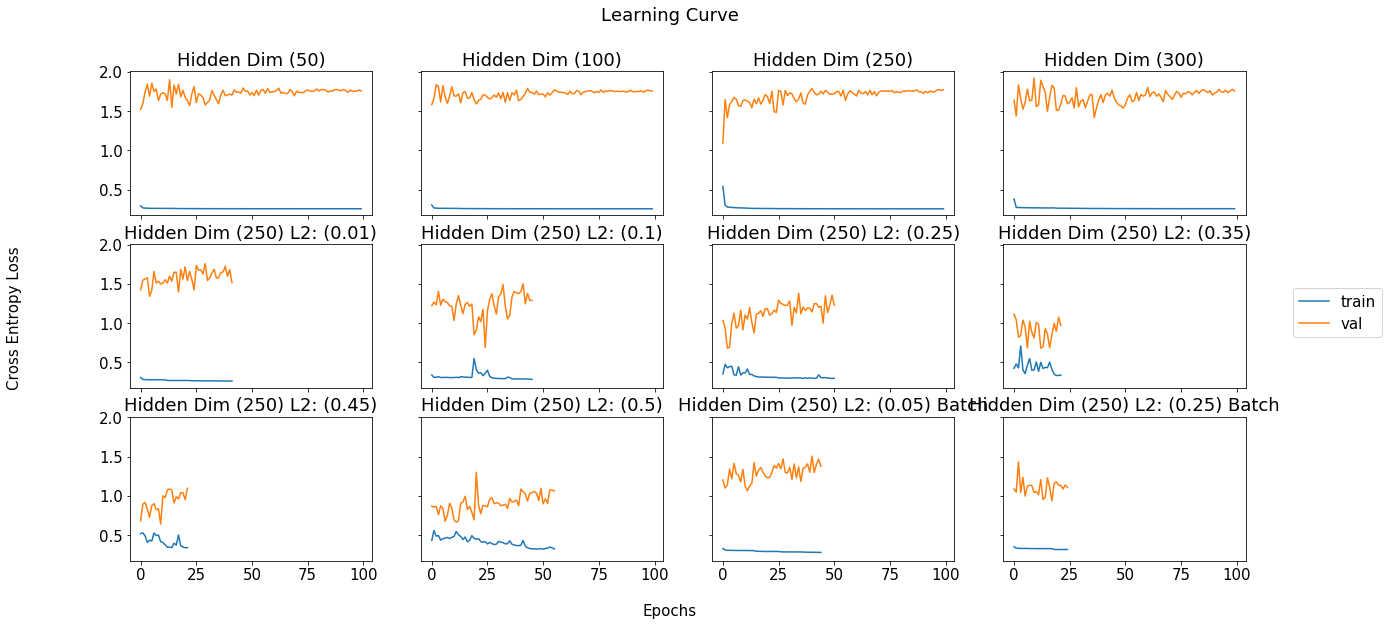

In [49]:
model_results = [
    lstm_results["LSTM Network 1"][0], lstm_results["LSTM Network 2"][0], 
    lstm_results["LSTM Network 3"][0], lstm_results["LSTM Network 4"][0],
    lstm_results["LSTM Network 5"][0], lstm_results["LSTM Network 6"][0],
    lstm_results["LSTM Network 7"][0], lstm_results["LSTM Network 8"][0], 
    lstm_results["LSTM Network 9"][0], lstm_results["LSTM Network 10"][0], 
    lstm_results["LSTM Network 11"][0], lstm_results["LSTM Network 12"][0],
]
labels = [
    "Hidden Dim (50)", "Hidden Dim (100)", 
    "Hidden Dim (250)", "Hidden Dim (300)",
    "Hidden Dim (250) L2: (0.01)", "Hidden Dim (250) L2: (0.1)",
    "Hidden Dim (250) L2: (0.25)", "Hidden Dim (250) L2: (0.35)", 
    "Hidden Dim (250) L2: (0.45)", "Hidden Dim (250) L2: (0.5)", 
    "Hidden Dim (250) L2: (0.05) Batch", "Hidden Dim (250) L2: (0.25) Batch"
]

plt.rcParams.update({'font.size':15})

fig, axn = plt.subplots(3,4, sharex=True, sharey=True)
fig.set_size_inches((20,9))
fig.suptitle("Learning Curve")
for i, (ax, data, plot_title) in enumerate(zip(axn.flat, model_results, labels)):
    l1, l2 = ax.plot(data['epoch'], data["train_loss"], data['epoch'], data["val_loss"])
    ax.set_title(plot_title)
    if i == 0:
        fig.legend((l1, l2), ("train", "val"), 'center right')
fig.text(0.5, 0.04, 'Epochs', ha='center')
fig.text(0.04, 0.5, 'Cross Entropy Loss', va='center', rotation='vertical')

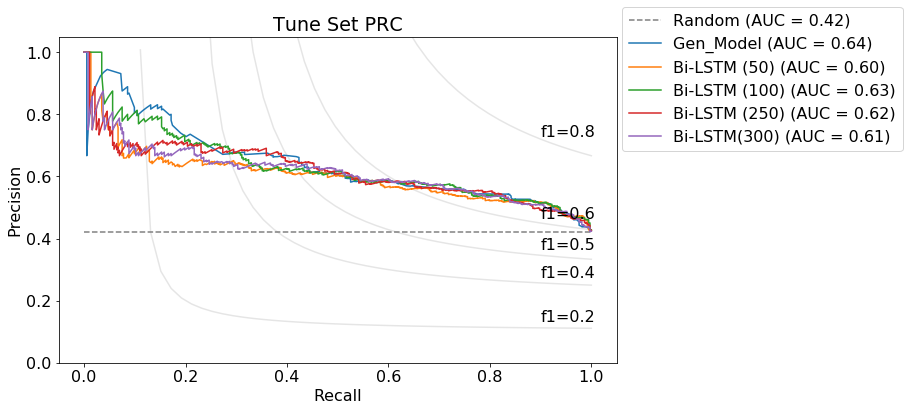

In [51]:
lstm_dev_hidden_df = pd.DataFrame(
        pd.np.stack([
            gen_model_dev_df["gen_model"].values,
            lstm_results["LSTM Network 1"][1][ lstm_results["LSTM Network 1"][3]].values,
            lstm_results["LSTM Network 2"][1][ lstm_results["LSTM Network 2"][3]].values,
            lstm_results["LSTM Network 3"][1][ lstm_results["LSTM Network 3"][3]].values,
            lstm_results["LSTM Network 4"][1][ lstm_results["LSTM Network 4"][3]].values,
        ],
            axis=1), 
        columns=[
            "Gen_Model", "Bi-LSTM (50)", 
            "Bi-LSTM (100)","Bi-LSTM (250)", 
            "Bi-LSTM(300)", 
                ]
    )
aucs=plot_curve(
    lstm_dev_hidden_df,
    dev_Y.numpy(), 
    plot_title="Tune Set PRC", 
    metric="PR", 
    model_type="curve"
)

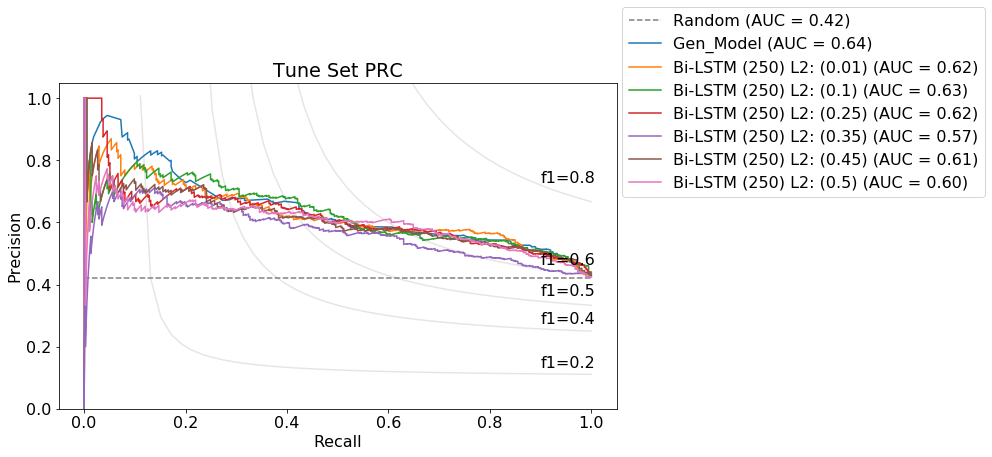

In [67]:
lstm_dev_l2_df = pd.DataFrame(
        pd.np.stack([
            gen_model_dev_df["gen_model"].values,
            lstm_results["LSTM Network 5"][1][ lstm_results["LSTM Network 5"][3]].values,
            lstm_results["LSTM Network 6"][1][ lstm_results["LSTM Network 6"][3]].values,
            lstm_results["LSTM Network 7"][1][ lstm_results["LSTM Network 7"][3]].values,
            lstm_results["LSTM Network 8"][1][ lstm_results["LSTM Network 8"][3]].values,
            lstm_results["LSTM Network 9"][1][ lstm_results["LSTM Network 9"][3]].values,
            lstm_results["LSTM Network 10"][1][ lstm_results["LSTM Network 10"][3]].values
        ],
            axis=1), 
        columns=["Gen_Model", "Bi-LSTM (250) L2: (0.01)", 
                 "Bi-LSTM (250) L2: (0.1)","Bi-LSTM (250) L2: (0.25)",
                 "Bi-LSTM (250) L2: (0.35)","Bi-LSTM (250) L2: (0.45)", 
                 "Bi-LSTM (250) L2: (0.5)"
                ]
    )
aucs=plot_curve(
    lstm_dev_l2_df,
    dev_Y.numpy(), 
    plot_title="Tune Set PRC", 
    metric="PR", 
    model_type="curve"
)

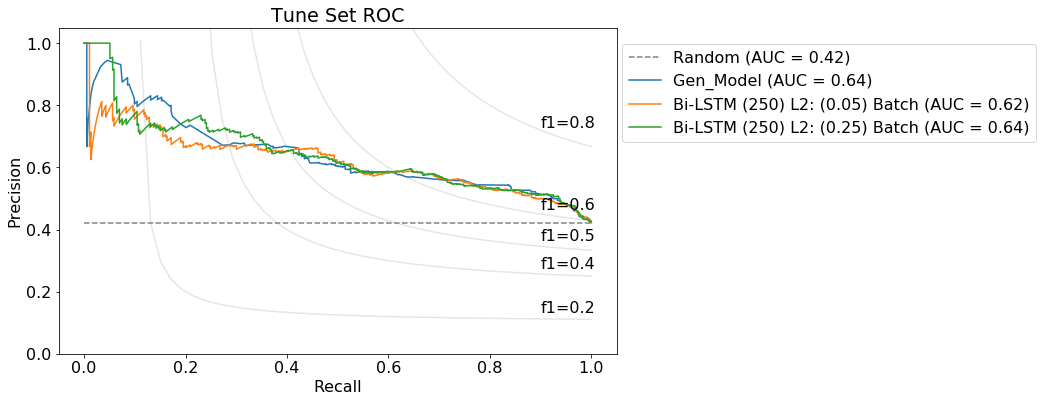

In [62]:
lstm_dev_batch_df = pd.DataFrame(
        pd.np.stack([
            gen_model_dev_df["gen_model"].values,
            lstm_results["LSTM Network 11"][1][ lstm_results["LSTM Network 11"][3]].values,
            lstm_results["LSTM Network 12"][1][ lstm_results["LSTM Network 12"][3]].values
        ],
            axis=1), 
        columns=["Gen_Model",  
                 "Bi-LSTM (250) L2: (0.05) Batch", 
                 "Bi-LSTM (250) L2: (0.25) Batch"
                ]
    )
aucs=plot_curve(
    lstm_dev_batch_df,
    dev_Y.numpy(), 
    plot_title="Tune Set PRC", 
    metric="PR", 
    model_type="curve"
)

In [ ]:
get_auc_significant_stats(
     dev_data
    .query("sen_length < @cutoff")
    .merge(candidate_dfs['dev']),
    aucs
)

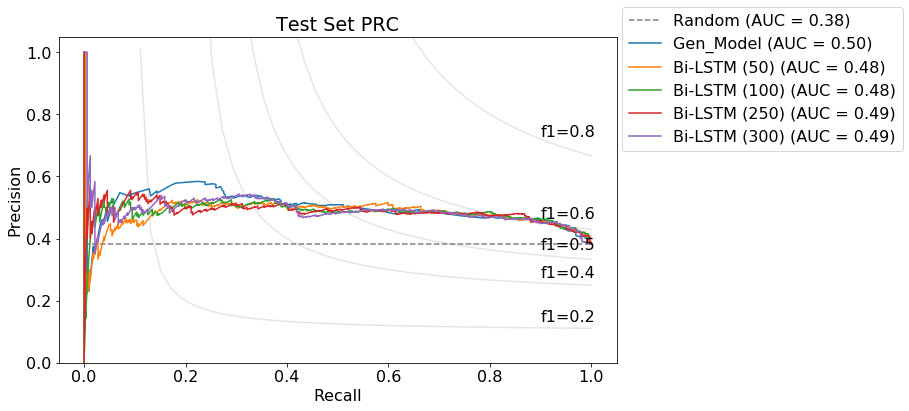

In [56]:
lstm_test_df = pd.DataFrame(
        pd.np.stack([
            gen_model_test_df["gen_model"].values,
            lstm_results["LSTM Network 1"][2][lstm_results["LSTM Network 1"][3]].values,
            lstm_results["LSTM Network 2"][2][lstm_results["LSTM Network 2"][3]].values,
            lstm_results["LSTM Network 3"][2][lstm_results["LSTM Network 3"][3]].values,
            lstm_results["LSTM Network 4"][2][lstm_results["LSTM Network 4"][3]].values,
        ],
            axis=1), 
        columns=["Gen_Model", "Bi-LSTM (50)", "Bi-LSTM (100)","Bi-LSTM (250)", "Bi-LSTM (300)", 
                ]
    )
aucs=plot_curve(
    lstm_test_df,
    test_Y.numpy(), 
    plot_title="Test Set PRC", 
    metric="PR", 
    model_type="curve"
)

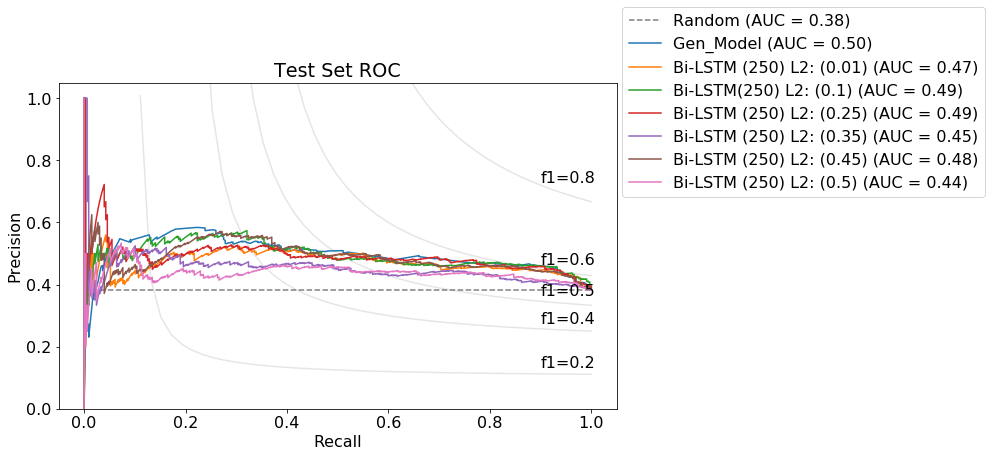

In [59]:
lstm_test_df = pd.DataFrame(
        pd.np.stack([
            gen_model_test_df["gen_model"].values,
            lstm_results["LSTM Network 5"][2][lstm_results["LSTM Network 5"][3]].values,
            lstm_results["LSTM Network 6"][2][lstm_results["LSTM Network 6"][3]].values,
            lstm_results["LSTM Network 7"][2][ lstm_results["LSTM Network 7"][3]].values,
            lstm_results["LSTM Network 8"][2][ lstm_results["LSTM Network 8"][3]].values,
            lstm_results["LSTM Network 9"][2][ lstm_results["LSTM Network 9"][3]].values,
            lstm_results["LSTM Network 10"][2][ lstm_results["LSTM Network 10"][3]].values,
        ],
            axis=1), 
        columns=["Gen_Model",
                 "Bi-LSTM (250) L2: (0.01)", "Bi-LSTM(250) L2: (0.1)",
                 "Bi-LSTM (250) L2: (0.25)", "Bi-LSTM (250) L2: (0.35)", 
                 "Bi-LSTM (250) L2: (0.45)", "Bi-LSTM (250) L2: (0.5)", 
                ]
    )
aucs=plot_curve(
    lstm_test_df,
    test_Y.numpy(), 
    plot_title="Test Set ROC", 
    metric="PR", 
    model_type="curve"
)

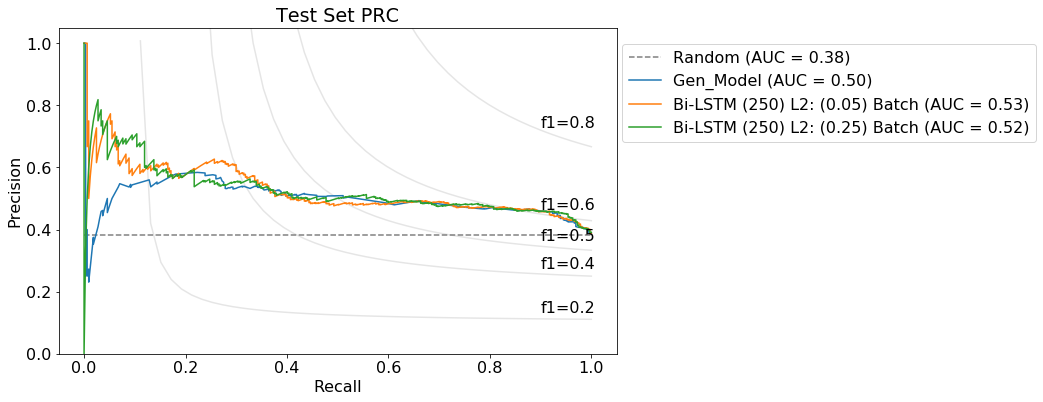

In [68]:
lstm_test_batch_df = pd.DataFrame(
        pd.np.stack([
            gen_model_test_df["gen_model"].values,
            lstm_results["LSTM Network 11"][2][ lstm_results["LSTM Network 11"][3]].values,
            lstm_results["LSTM Network 12"][2][ lstm_results["LSTM Network 12"][3]].values,
        ],
            axis=1), 
        columns=["Gen_Model",
                 "Bi-LSTM (250) L2: (0.05) Batch", 
                 "Bi-LSTM (250) L2: (0.25) Batch", 
                ]
    )
aucs=plot_curve(
    lstm_test_batch_df,
    test_Y.numpy(), 
    plot_title="Test Set PRC", 
    metric="PR", 
    model_type="curve"
)

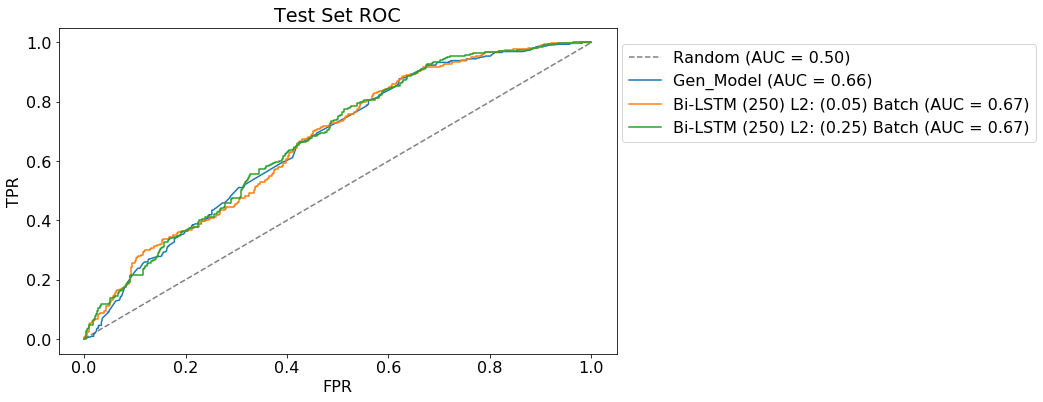

In [80]:
lstm_test_batch_df = pd.DataFrame(
        pd.np.stack([
            gen_model_test_df["gen_model"].values,
            lstm_results["LSTM Network 11"][2][ lstm_results["LSTM Network 11"][3]].values,
            lstm_results["LSTM Network 12"][2][ lstm_results["LSTM Network 12"][3]].values,
        ],
            axis=1), 
        columns=["Gen_Model",
                 "Bi-LSTM (250) L2: (0.05) Batch", 
                 "Bi-LSTM (250) L2: (0.25) Batch", 
                ]
    )
aucs=plot_curve(
    lstm_test_batch_df,
    test_Y.numpy(), 
    plot_title="Test Set ROC", 
    metric="ROC", 
    model_type="curve"
)

In [81]:
get_auc_significant_stats(
     test_data
    .query("sen_length < @cutoff")
    .merge(candidate_dfs['test']),
    aucs
)

mu: 86328.000000, sigma: 3509.434142


,auroc,u,z_u,p_value
Gen_Model,0.663415,114542.5,8.039615,4.506052e-16
Bi-LSTM (250) L2: (0.05) Batch,0.666638,115099.0,8.198188,1.220190e-16
Bi-LSTM (250) L2: (0.25) Batch,0.669852,115654.0,8.356333,3.234898e-17


# Visualize LSTM Attention Layer

The attention layer is a useful tool, because it is a linear combination of all the hidden states that are outputted from an LSTM network or any given recurrent neural network. Based on this fact, the hidden state that receives a higher weight means that word contributes more towards the final output than the other hidden states. Below in this network are heatmaps that show what words our LSTM network is paying close attention to and which words it is ignoring.

In [69]:
word_dict_df = pd.read_table("data/word_dictionary.tsv.xz")
reverse_dict = {index:word for word, index in word_dict_df[["word", "index"]].values}
word_dict_df.head(2)

,word,index
0,of,2
1,~~[[2,3


### Positive Sentence Example

In [70]:
index = 422
words = [reverse_dict[col.item()] for col in dev_X[index] if col > 0]
attn_df_dict = get_attn_scores(lstm_model_paths, lstm_end_models, dev_X[index:index+1], words)

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

In [76]:
print(" ".join(words))
print()
print("P(Y|X) = {:.2f}".format(lstm_results["LSTM Network 10"][1][lstm_results["LSTM Network 10"][3]].iloc[index]))
print("True Y = {}".format(dev_Y[index]))

results : tissue explants of ~~[[1 bcc 1]]~~ contained significantly higher concentrations of ~~[[2 il-1beta 2]]~~ , il-4 , il-5 , and il-6 compared to those of squamous cell tumors .

P(Y|X) = 0.53
True Y = 1


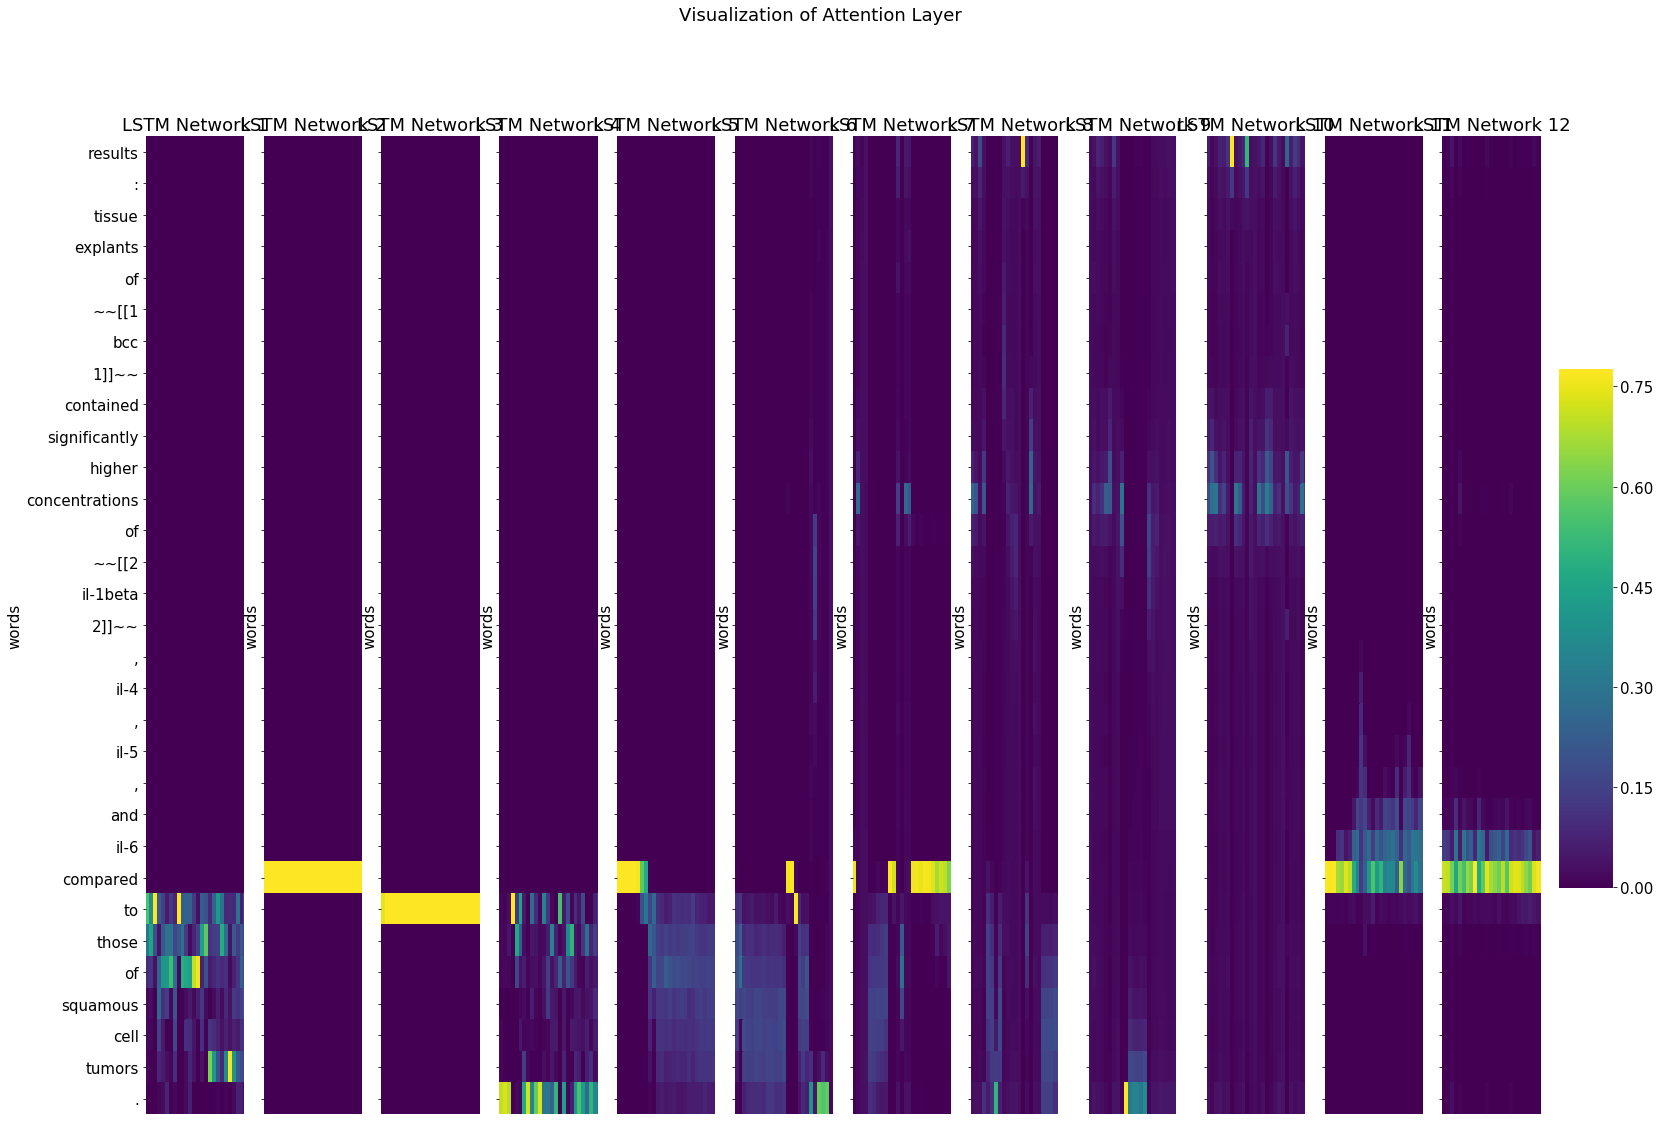

In [73]:
plt.rcParams.update({'font.size':15})
fig, axn = plt.subplots(1, 12, sharex=True, sharey=True)
fig.set_size_inches((25,18))
fig.suptitle("Visualization of Attention Layer")
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, (ax, key) in enumerate(zip(axn.flat, attn_df_dict.keys())):
    sns.heatmap(
        attn_df_dict[key].set_index("words"),
        annot=False,
        cmap='viridis',
        xticklabels=False,
        ax=ax,
        cbar_ax = None if i else cbar_ax,
        cbar = (i==0)
    )
    ax.set_title(key)

### Negative Sentence Example

In [143]:
index = 15
words = [reverse_dict[col.item()] for col in dev_X[index] if col > 0]
attn_df_dict = get_attn_scores(lstm_model_paths, lstm_end_models, dev_X[index:index+1], words)

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

In [144]:
print(" ".join(words))
print()
print("P(Y|X) = {:.2f}".format(lstm_results["LSTM Network 12"][1][lstm_results["LSTM Network 12"][3]].iloc[index]))
print("True Y = {}".format(dev_Y[index]))

these results suggest that both ~~[[2 insulin 2]]~~ resistance and ~~[[1 obesity 1]]~~ are independently associated with impaired tef at rest , but the responsiveness of thermogenesis to exercise before a meal is related to the obese state and not independently to insulin resistance per se .

P(Y|X) = 0.99
True Y = 2


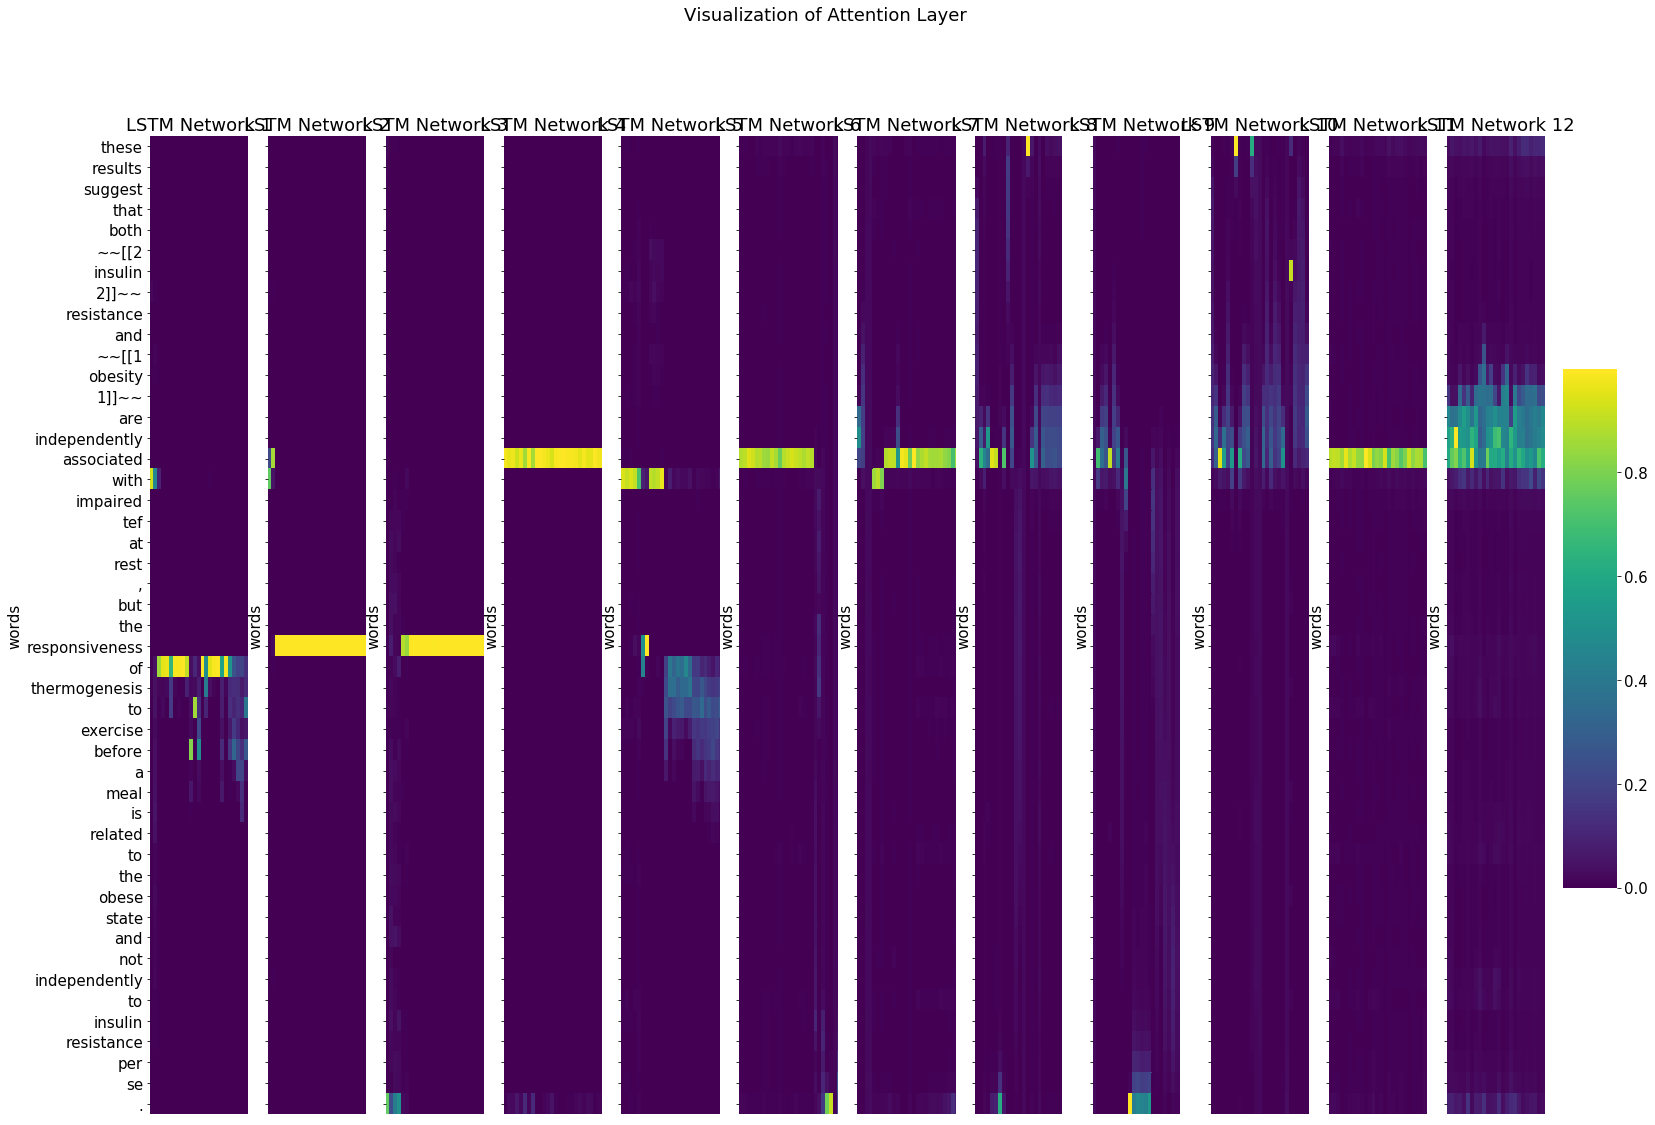

In [145]:
plt.rcParams.update({'font.size':15})
fig, axn = plt.subplots(1, 12, sharex=True, sharey=True)
fig.set_size_inches((25,18))
fig.suptitle("Visualization of Attention Layer")
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, (ax, key) in enumerate(zip(axn.flat, attn_df_dict.keys())):
    sns.heatmap(
        attn_df_dict[key].set_index("words"),
        annot=False,
        cmap='viridis',
        xticklabels=False,
        yticklabels = True,
        ax=ax,
        cbar_ax = None if i else cbar_ax,
        cbar = (i==0)
    )
    ax.set_title(key)

In [85]:
test_sentence = ["the", "gene",  "~~[[2", "brca2", "2]]~~", "is", "not", "expressed", "in", "~~[[1", "cancer","1]]~~","."]
test_data_point = torch.LongTensor([list(map(lambda x: word_dict_df.query("word==@x")['index'].values[0], test_sentence))])
attn_df_dict = get_attn_scores(lstm_model_paths, lstm_end_models, test_data_point, test_sentence)

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

In [86]:
print(" ".join(test_sentence))
print()
print("P(Y|X) = {:.2f}".format(lstm_end_models["LSTM Network 3"].predict_proba(test_data_point)[:,0][0]))
print("True Y = {}".format(1))

the gene ~~[[2 brca2 2]]~~ is not expressed in ~~[[1 cancer 1]]~~ .

P(Y|X) = 1.00
True Y = 1


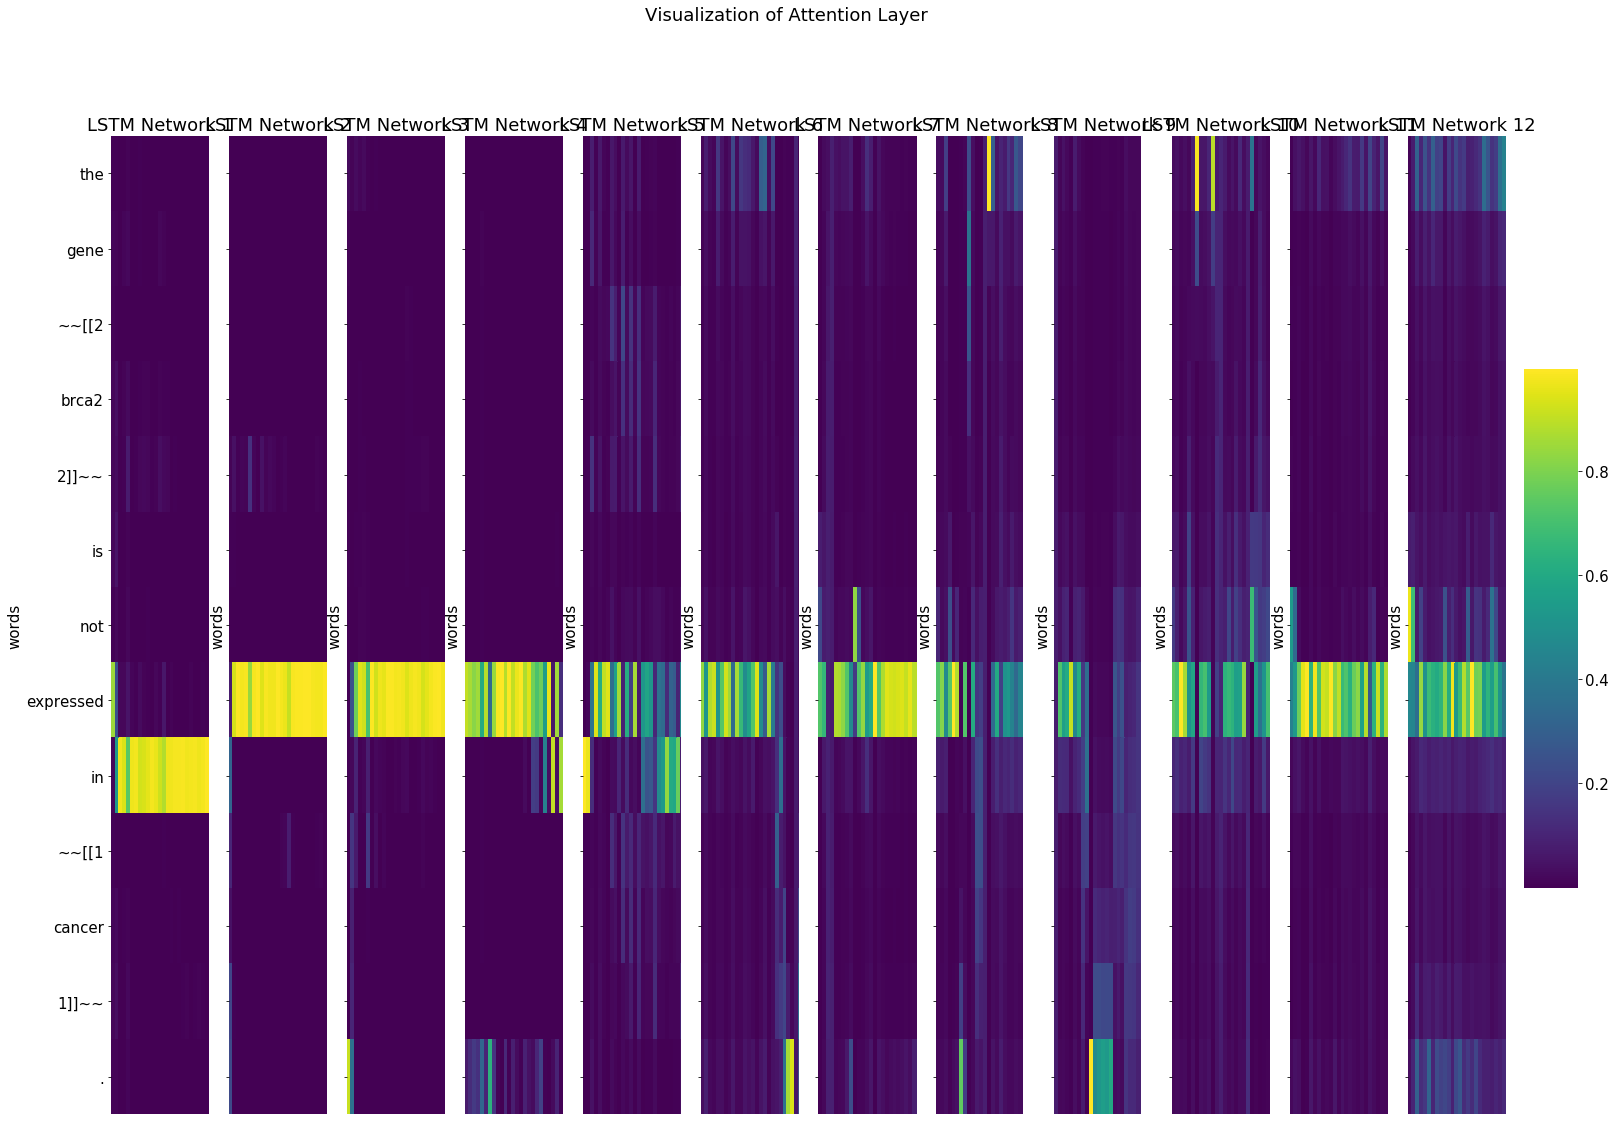

In [87]:
plt.rcParams.update({'font.size':15})
fig, axn = plt.subplots(1, 12, sharex=True, sharey=True)
fig.set_size_inches((25,18))
fig.suptitle("Visualization of Attention Layer")
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, (ax, key) in enumerate(zip(axn.flat, attn_df_dict.keys())):
    sns.heatmap(
        attn_df_dict[key].set_index("words"),
        annot=False,
        cmap='viridis',
        xticklabels=False,
        yticklabels = True,
        ax=ax,
        cbar_ax = None if i else cbar_ax,
        cbar = (i==0)
    )
    ax.set_title(key)
    torch.LongTensor([list(map(lambda x: word_dict_df.query("word==@x")['index'].values[0], ["the", "gene", "brca2", "is", "not", "associated", "with", "cancer"]))])

In [88]:
test_sentence = ["the", "gene", "~~[[2", "brca2","2]]~~", "is", "highly", "expressed", "in", "~~[[1", "cancer","1]]~~", "."]
test_data_point = torch.LongTensor([list(map(lambda x: word_dict_df.query("word==@x")['index'].values[0], test_sentence))])
attn_df_dict = get_attn_scores(lstm_model_paths, lstm_end_models, test_data_point, test_sentence)

HBox(children=(IntProgress(value=0, max=12), HTML(value='')))

In [92]:
print(" ".join(test_sentence))
print()
print("P(Y|X) = {:.2f}".format(lstm_end_models["LSTM Network 11"].predict_proba(test_data_point)[:,0][0]))
print("True Y = {}".format(1))

the gene ~~[[2 brca2 2]]~~ is highly expressed in ~~[[1 cancer 1]]~~ .

P(Y|X) = 1.00
True Y = 1


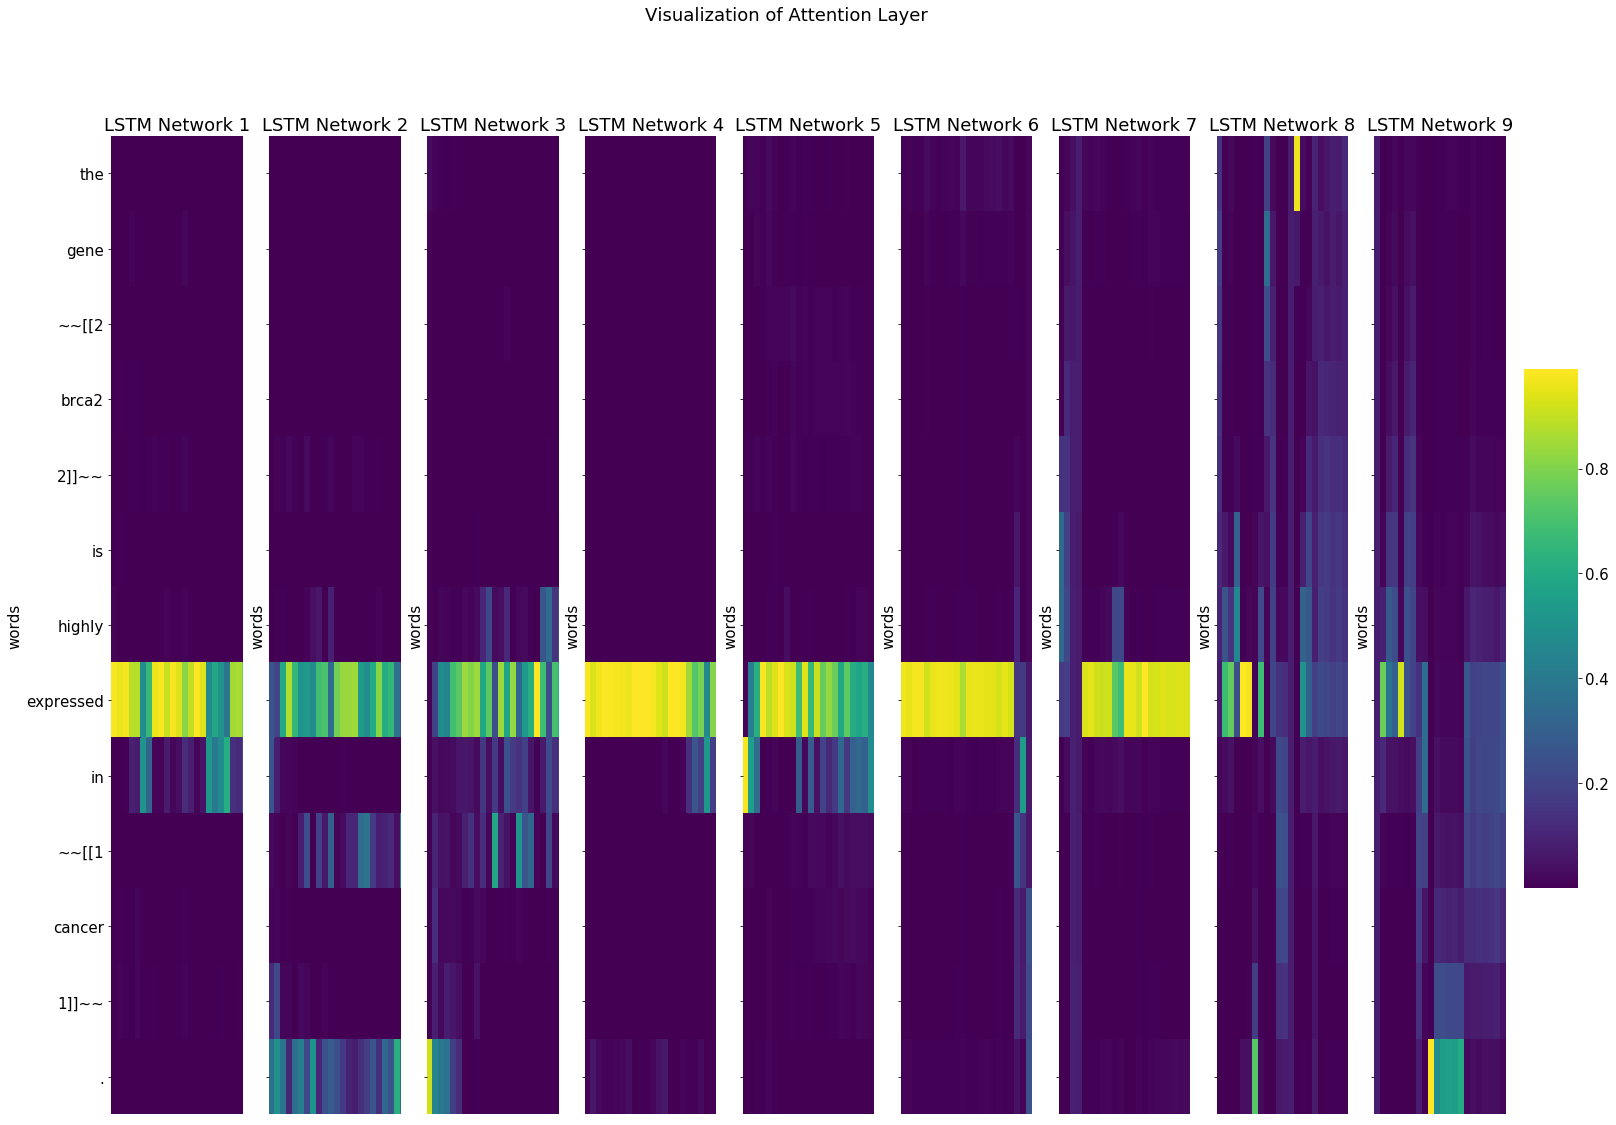

In [90]:
plt.rcParams.update({'font.size':15})
fig, axn = plt.subplots(1, 9, sharex=True, sharey=True)
fig.set_size_inches((25,18))
fig.suptitle("Visualization of Attention Layer")
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, (ax, key) in enumerate(zip(axn.flat, attn_df_dict.keys())):
    sns.heatmap(
        attn_df_dict[key].set_index("words"),
        annot=False,
        cmap='viridis',
        xticklabels=False,
        yticklabels = True,
        ax=ax,
        cbar_ax = None if i else cbar_ax,
        cbar = (i==0)
    )
    ax.set_title(key)
    torch.LongTensor([list(map(lambda x: word_dict_df.query("word==@x")['index'].values[0], ["the", "gene", "brca2", "is", "not", "associated", "with", "cancer"]))])

# CNN Network Evaluation

Used a Convolutional neural network with two fully connected layers at the end. The following parameters for this network are produced below in the table:

| Parameter | Network 1 | Network 2 | Network 3 | Network 4 | Network 5 |
|-------|-------|-------|-------|-------|-------|
| Word Embeddings | 300 dim (fixed) | 300 dim (fixed) | 300 dim (fixed) | 300 dim (fixed) | 300 dim (free) |
| kernel Sizes | 7,7,7,7 | 7,7,7,7 | 3,4,5,6 | 10,10,10,10 | 7,7,7,7 |
| Batch Norm | Yes | No | Yes | Yes | Yes |
| Dropout | 0.5 (outside) | 0.5 (outside) | 0.5 (outside) | 0.5 (outside) | 0.5 (outside) | 
| Layers | 2 | 2 | 2 | 2 | 2 | 
| learning rate | 0.0001 |  0.0001 |  0.0001 |  0.0001 | 0.0001 | 
| optimizer | adam with betas(0.9, 0.99)| adam with betas(0.9, 0.99)| adam with betas(0.9, 0.99)| adam with betas(0.9, 0.99)| adam with betas(0.9, 0.99)|
| Batch Size | 256 | 256 | 256 | 256 | 256 |
    

In [93]:
cnn_params = {
    "CNN Network 1":
    {
        "hidden_size":300,
        "output_size":2,
        "seed":100,
        "kernel_sizes":[7,7,7,7],
        "vocab_size":word_vectors.shape[0]+2,
        "batchnorm":True
    },
    "CNN Network 2":
    {
        "hidden_size":300,
        "output_size":2,
        "seed":100,
        "kernel_sizes":[7,7,7,7],
        "vocab_size":word_vectors.shape[0]+2,
        "batchnorm":False
    },
    "CNN Network 3":{
        "hidden_size":300,
        "output_size":2,
        "seed":100,
        "kernel_sizes":[3,4,5,6],
        "vocab_size":word_vectors.shape[0]+2,
        "batchnorm":True
    },
    "CNN Network 4":
    {
        "hidden_size":300,
        "output_size":2,
        "seed":100,
        "kernel_sizes":[10,10,10,10],
        "vocab_size":word_vectors.shape[0]+2,
        "batchnorm":True
    },
    "CNN Network 5":
    {
        "hidden_size":300,
        "output_size":2,
        "seed":100,
        "kernel_sizes":[7,7,7,7],
        "vocab_size":word_vectors.shape[0]+2,
        "batchnorm":True
    },
    "CNN Network 6":
    {
        "hidden_size":300,
        "output_size":2,
        "seed":100,
        "kernel_sizes":[7,7,7,7],
        "vocab_size":word_vectors.shape[0]+2,
        "batchnorm":True,
        "l2":0.5
    },
    "CNN Network 7":
    {
        "hidden_size":300,
        "output_size":2,
        "seed":100,
        "kernel_sizes":[7,7,7,7],
        "vocab_size":word_vectors.shape[0]+2,
        "batchnorm":True,
        "l2":2
    },
    "CNN Network 8":
    {
        "hidden_size":300,
        "output_size":2,
        "seed":100,
        "kernel_sizes":[7,7,7,7],
        "vocab_size":word_vectors.shape[0]+2,
        "batchnorm":True,
        "l2":3.5
    },
    "CNN Network 9":
    {
        "hidden_size":300,
        "output_size":2,
        "seed":100,
        "kernel_sizes":[7,7,7,7],
        "vocab_size":word_vectors.shape[0]+2,
        "batchnorm":True,
        "l2":5
    }
}

In [94]:
cnn_model_paths = {
    "CNN Network 1":sorted(
        glob.glob("data/final_models/fixed_index/cnn/100_4_7777_frozen_0.0001_batch_norm/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "CNN Network 2":sorted(
        glob.glob("data/final_models/fixed_index/cnn/100_4_7777_frozen_0.0001_no_batch_norm/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "CNN Network 3":sorted(
        glob.glob("data/final_models/fixed_index/cnn/100_4_3456_frozen_0.0001_batch_norm/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "CNN Network 4":sorted(
        glob.glob("data/final_models/fixed_index/cnn/100_4_10101010_frozen_0.0001_batch_norm/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "CNN Network 5":sorted(
        glob.glob("data/final_models/fixed_index/cnn/100_4_7777_free_0.0001_batch_norm/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "CNN Network 6":sorted(
        glob.glob("data/final_models/fixed_index/cnn/100_4_7777_frozen_0.0001_batch_norm_0.5/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "CNN Network 7":sorted(
        glob.glob("data/final_models/fixed_index/cnn/100_4_7777_frozen_0.0001_batch_norm_2/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "CNN Network 8":sorted(
        glob.glob("data/final_models/fixed_index/cnn/100_4_7777_frozen_0.0001_batch_norm_3.5/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
    "CNN Network 9":sorted(
        glob.glob("data/final_models/fixed_index/cnn/100_4_7777_frozen_0.0001_batch_norm_5/*checkpoint*"),
        key=lambda x: int(re.search(r'([\d]+)', os.path.basename(x)).group())
    ),
}

In [95]:
cnn_end_models= {}

In [96]:
for network in cnn_params:
    cnn_end_models[network] = EndModel(
    [cutoff-1, 50, 2], 
    input_module=PaddedEmbeddings(
        cnn_params[network]["vocab_size"], cnn_params[network]["hidden_size"], freeze=True
        ),
    middle_modules=[CNN(100, cnn_params[network]["kernel_sizes"], 59, 300)],
    seed=cnn_params[network]["seed"], 
    use_cuda=False,
    middle_layer_config = {
    'middle_relu':False,
    'middle_dropout': 0.25,
    'middle_batchnorm':cnn_params[network]["batchnorm"],
    },
    input_layer_config = {
        'input_relu':False,
        'input_batchnorm':False,
        'input_dropout': 0,
    }
)


Network architecture:
Sequential(
  (0): PaddedEmbeddings(
    (embed): Embedding(54074, 300, padding_idx=0)
  )
  (1): Sequential(
    (0): CNN(
      (conv1): Conv2d(1, 100, kernel_size=(7, 300), stride=(1, 1))
      (pool1): MaxPool2d(kernel_size=(53, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
      (conv2): Conv2d(1, 100, kernel_size=(7, 300), stride=(1, 1))
      (pool2): MaxPool2d(kernel_size=(53, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
      (conv3): Conv2d(1, 100, kernel_size=(7, 300), stride=(1, 1))
      (pool3): MaxPool2d(kernel_size=(53, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
      (conv4): Conv2d(1, 100, kernel_size=(7, 300), stride=(1, 1))
      (pool4): MaxPool2d(kernel_size=(53, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=400, out_features=100, bias=True)
      (fc2): Linear(in_features=100, out_features=50, bias=True)
    )
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, t


Network architecture:
Sequential(
  (0): PaddedEmbeddings(
    (embed): Embedding(54074, 300, padding_idx=0)
  )
  (1): Sequential(
    (0): CNN(
      (conv1): Conv2d(1, 100, kernel_size=(7, 300), stride=(1, 1))
      (pool1): MaxPool2d(kernel_size=(53, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
      (conv2): Conv2d(1, 100, kernel_size=(7, 300), stride=(1, 1))
      (pool2): MaxPool2d(kernel_size=(53, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
      (conv3): Conv2d(1, 100, kernel_size=(7, 300), stride=(1, 1))
      (pool3): MaxPool2d(kernel_size=(53, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
      (conv4): Conv2d(1, 100, kernel_size=(7, 300), stride=(1, 1))
      (pool4): MaxPool2d(kernel_size=(53, 1), stride=1, padding=0, dilation=1, ceil_mode=False)
      (fc1): Linear(in_features=400, out_features=100, bias=True)
      (fc2): Linear(in_features=100, out_features=50, bias=True)
    )
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, t

In [ ]:
cnn_results = {}
for network in cnn_model_paths:
    cnn_results[network] = get_network_results(
        cnn_model_paths[network], cnn_end_models[network], 
        dev_X, test_X
    )

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

HBox(children=(IntProgress(value=0), HTML(value='')))

In [102]:
cnn_results[network][0].head(2)

,epoch,train_loss,val_loss,lr,f1
0,0.0,0.372410,0.936025,0.0001,0.559557
1,1.0,0.307466,0.926331,0.0001,0.550279


In [103]:
cnn_results[network][1].head(2)

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0.171086,0.135421,0.159778,0.178396,0.160643,0.161984,0.195956,0.180500,0.172514,0.193123,...,0.190707,0.182615,0.183883,0.189580,0.166981,0.178755,0.165167,0.185603,0.193114,0.176694
1,0.176034,0.144722,0.157212,0.157882,0.124928,0.138969,0.144862,0.137194,0.157677,0.140974,...,0.143410,0.148539,0.160416,0.154588,0.120925,0.139772,0.138890,0.144353,0.133637,0.130638


In [104]:
cnn_results[network][2].head(2)

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,0.086028,0.028118,0.031447,0.046439,0.039984,0.036538,0.033276,0.034853,0.033999,0.033955,...,0.030943,0.029220,0.027203,0.035055,0.043256,0.039175,0.032902,0.025418,0.028343,0.036959
1,0.241164,0.158156,0.157715,0.192252,0.177345,0.177475,0.191463,0.172552,0.154252,0.160873,...,0.189324,0.194396,0.209637,0.204376,0.185312,0.190288,0.182044,0.179781,0.184145,0.165291


In [105]:
cnn_results[network][3]

3

Text(0.04,0.5,'Cross Entropy Loss')

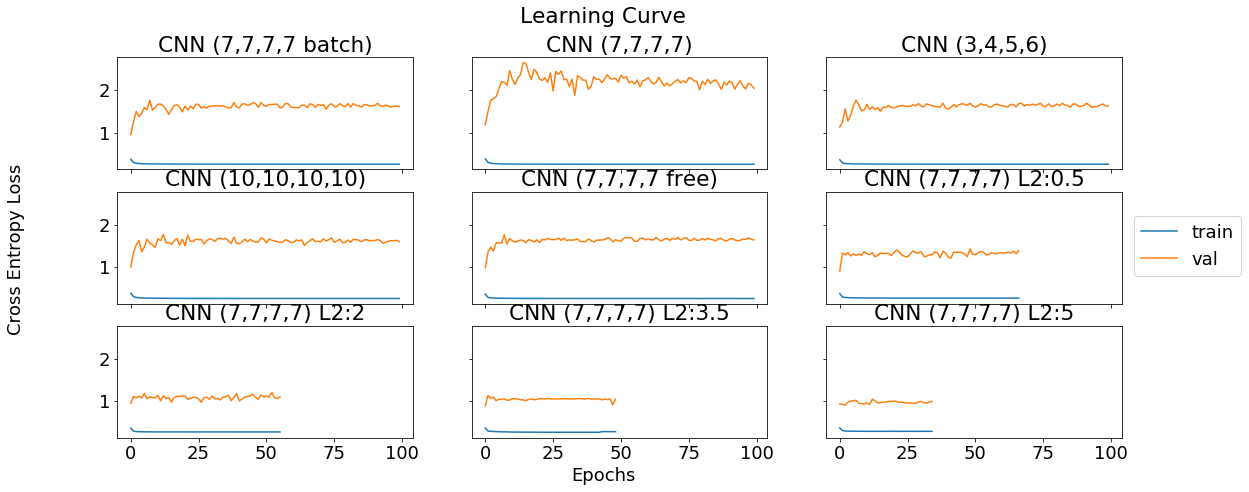

In [106]:
cnn_model_results = [
    cnn_results["CNN Network 1"][0],cnn_results["CNN Network 2"][0],
    cnn_results["CNN Network 3"][0], cnn_results["CNN Network 4"][0],
    cnn_results["CNN Network 5"][0], cnn_results["CNN Network 6"][0],
    cnn_results["CNN Network 7"][0], cnn_results["CNN Network 8"][0],
    cnn_results["CNN Network 9"][0]
]
cnn_labels = [
    "CNN (7,7,7,7 batch)", "CNN (7,7,7,7)", 
    "CNN (3,4,5,6)", "CNN (10,10,10,10)",
    "CNN (7,7,7,7 free)", "CNN (7,7,7,7) L2:0.5", 
    "CNN (7,7,7,7) L2:2", "CNN (7,7,7,7) L2:3.5", 
    "CNN (7,7,7,7) L2:5"
]

plt.rcParams.update({'font.size':18})

fig, axn = plt.subplots(3, 3, sharex=True, sharey=True)
fig.set_size_inches((18,7))
fig.suptitle("Learning Curve")
for i, (ax, data, plot_title) in enumerate(zip(axn.flat, cnn_model_results, cnn_labels)):
    l1, l2 = ax.plot(data['epoch'], data["train_loss"], data['epoch'], data["val_loss"])
    ax.set_title(plot_title)
    if i == 0:
        fig.legend((l1, l2), ("train", "val"), 'center right')
fig.text(0.5, 0.04, 'Epochs', ha='center')
fig.text(0.04, 0.5, 'Cross Entropy Loss', va='center', rotation='vertical')

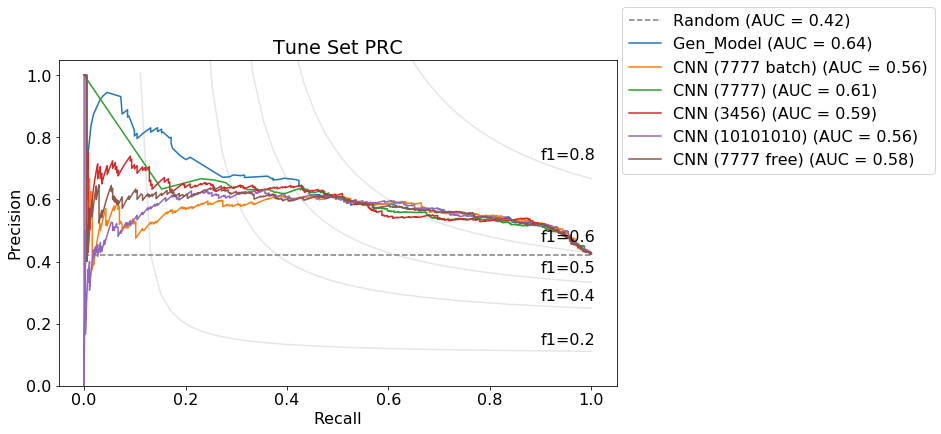

In [116]:
cnn_dev_df = pd.DataFrame(
        pd.np.stack([
            gen_model_dev_df["gen_model"].values,
            cnn_results["CNN Network 1"][1][cnn_results["CNN Network 1"][3]].values,
            cnn_results["CNN Network 2"][1][cnn_results["CNN Network 2"][3]].values,
            cnn_results["CNN Network 3"][1][cnn_results["CNN Network 3"][3]].values,
            cnn_results["CNN Network 4"][1][cnn_results["CNN Network 4"][3]].values,
            cnn_results["CNN Network 5"][1][cnn_results["CNN Network 5"][3]].values,
        ],
            axis=1), 
        columns=[
            "Gen_Model", "CNN (7777 batch)", 
            "CNN (7777)", "CNN (3456)", 
            "CNN (10101010)", "CNN (7777 free)"
        ]
    )
aucs=plot_curve(
    cnn_dev_df,
    dev_Y.numpy(), 
    plot_title="Tune Set PRC", 
    metric="PR", 
    model_type="curve"
)

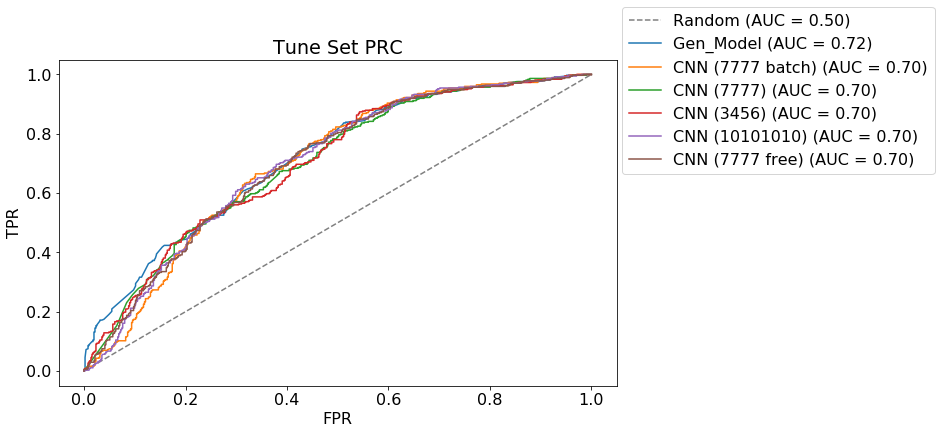

In [117]:
cnn_dev_df = pd.DataFrame(
        pd.np.stack([
            gen_model_dev_df["gen_model"].values,
            cnn_results["CNN Network 1"][1][cnn_results["CNN Network 1"][3]].values,
            cnn_results["CNN Network 2"][1][cnn_results["CNN Network 2"][3]].values,
            cnn_results["CNN Network 3"][1][cnn_results["CNN Network 3"][3]].values,
            cnn_results["CNN Network 4"][1][cnn_results["CNN Network 4"][3]].values,
            cnn_results["CNN Network 5"][1][cnn_results["CNN Network 5"][3]].values,
        ],
            axis=1), 
        columns=[
            "Gen_Model", "CNN (7777 batch)", 
            "CNN (7777)", "CNN (3456)", 
            "CNN (10101010)", "CNN (7777 free)"
        ]
    )
aucs=plot_curve(
    cnn_dev_df,
    dev_Y.numpy(), 
    plot_title="Tune Set ROC", 
    metric="ROC", 
    model_type="curve"
)

In [118]:
get_auc_significant_stats(
     dev_data
    .query("sen_length < @cutoff")
    .merge(candidate_dfs['dev']),
    aucs
)

mu: 95488.000000, sigma: 3755.049223


,auroc,u,z_u,p_value
Gen_Model,0.717391,137004.5,11.056180,1.023141e-28
CNN (7777 batch),0.700955,133865.5,10.220239,8.047190e-25
CNN (7777),0.699871,133658.5,10.165113,1.418963e-24
CNN (3456),0.701224,133917.0,10.233954,6.984848e-25
CNN (10101010),0.702837,134225.0,10.315977,2.983576e-25
CNN (7777 free),0.701730,134013.5,10.259652,5.354573e-25


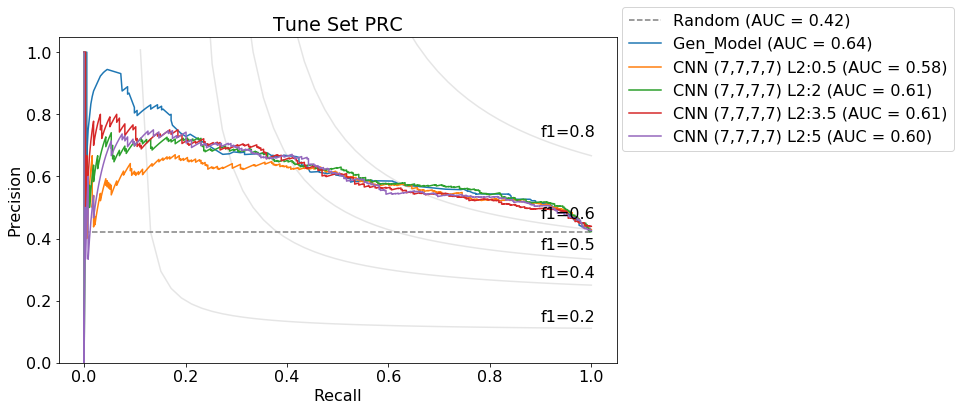

In [115]:
cnn_dev_df = pd.DataFrame(
        pd.np.stack([
            gen_model_dev_df["gen_model"].values,
            cnn_results["CNN Network 6"][1][cnn_results["CNN Network 6"][3]].values,
            cnn_results["CNN Network 7"][1][cnn_results["CNN Network 7"][3]].values,
            cnn_results["CNN Network 8"][1][cnn_results["CNN Network 8"][3]].values,
            cnn_results["CNN Network 9"][1][cnn_results["CNN Network 9"][3]].values,
        ],
            axis=1), 
        columns=[
            "Gen_Model","CNN (7,7,7,7) L2:0.5", 
            "CNN (7,7,7,7) L2:2", "CNN (7,7,7,7) L2:3.5", 
            "CNN (7,7,7,7) L2:5"
        ]
    )
aucs=plot_curve(
    cnn_dev_df,
    dev_Y.numpy(), 
    plot_title="Tune Set PRC", 
    metric="PR", 
    model_type="curve"
)

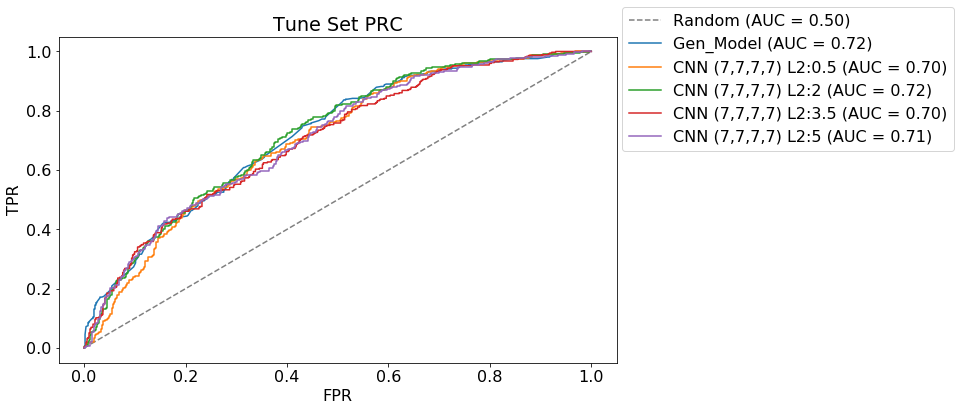

In [119]:
cnn_dev_df = pd.DataFrame(
        pd.np.stack([
            gen_model_dev_df["gen_model"].values,
            cnn_results["CNN Network 6"][1][cnn_results["CNN Network 6"][3]].values,
            cnn_results["CNN Network 7"][1][cnn_results["CNN Network 7"][3]].values,
            cnn_results["CNN Network 8"][1][cnn_results["CNN Network 8"][3]].values,
            cnn_results["CNN Network 9"][1][cnn_results["CNN Network 9"][3]].values,
        ],
            axis=1), 
        columns=[
            "Gen_Model","CNN (7,7,7,7) L2:0.5", 
            "CNN (7,7,7,7) L2:2", "CNN (7,7,7,7) L2:3.5", 
            "CNN (7,7,7,7) L2:5"
        ]
    )
aucs=plot_curve(
    cnn_dev_df,
    dev_Y.numpy(), 
    plot_title="Tune Set ROC", 
    metric="ROC", 
    model_type="curve"
)

In [120]:
get_auc_significant_stats(
     dev_data
    .query("sen_length < @cutoff")
    .merge(candidate_dfs['dev']),
    aucs
)

mu: 95488.000000, sigma: 3755.049223


,auroc,u,z_u,p_value
Gen_Model,0.717391,137004.5,11.056180,1.023141e-28
"CNN (7,7,7,7) L2:0.5",0.701570,133983.0,10.251530,5.824240e-25
"CNN (7,7,7,7) L2:2",0.718991,137310.0,11.137537,4.118284e-29
"CNN (7,7,7,7) L2:3.5",0.701845,134035.5,10.265511,5.039285e-25
"CNN (7,7,7,7) L2:5",0.705314,134698.0,10.441940,7.975818e-26


In [132]:
best_cnn_dev = cnn_results["CNN Network 7"][1][cnn_results["CNN Network 7"][3]].values 
best_lstm_dev = lstm_results["LSTM Network 12"][1][lstm_results["LSTM Network 12"][3]].values 
best_cnn_test = cnn_results["CNN Network 7"][2][cnn_results["CNN Network 7"][3]].values 
best_lstm_test = lstm_results["LSTM Network 12"][2][lstm_results["LSTM Network 12"][3]].values 

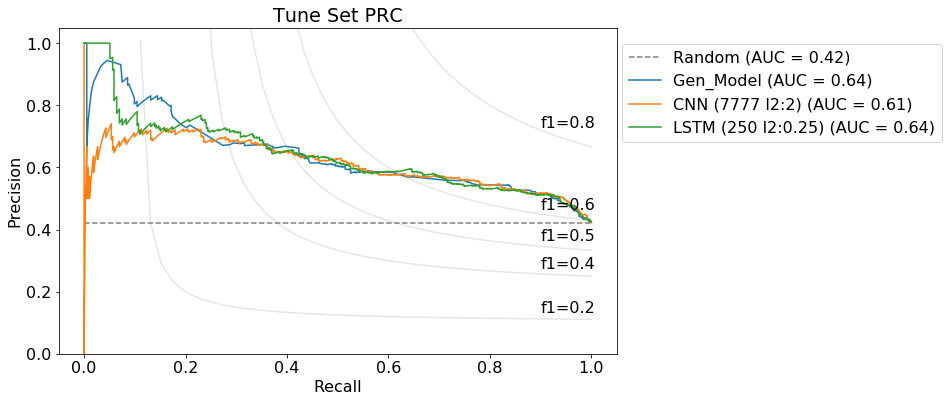

In [133]:
final_dev_df = pd.DataFrame(
        pd.np.stack([
            gen_model_dev_df["gen_model"].values,
            best_cnn_dev,
            best_lstm_dev
        ],
            axis=1), 
        columns=["Gen_Model", "CNN (7777 l2:2)", "LSTM (250 l2:0.25)"]
    )
aucs=plot_curve(
    final_dev_df,
    dev_Y.numpy(), 
    plot_title="Tune Set PRC", 
    metric="PR", 
    model_type="curve"
)

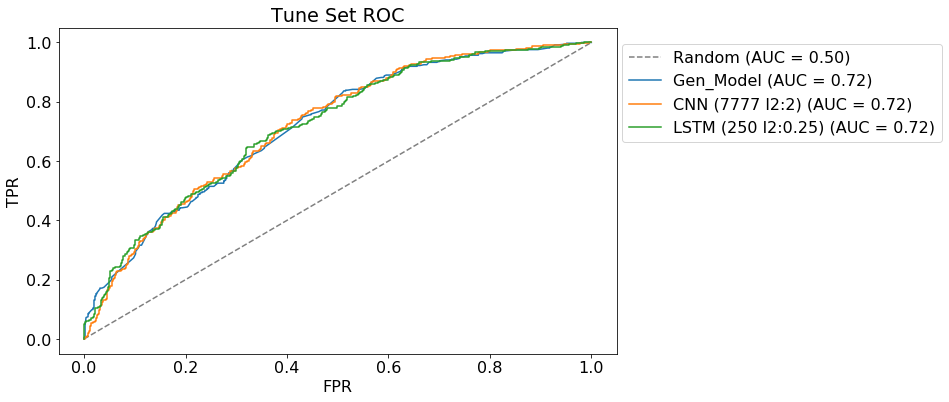

In [134]:
aucs=plot_curve(
    final_dev_df,
    dev_Y.numpy(), 
    plot_title="Tune Set ROC", 
    metric="ROC", 
    model_type="curve"
)

In [135]:
get_auc_significant_stats(
     dev_data
    .query("sen_length < @cutoff")
    .merge(candidate_dfs['dev']),
    aucs
)

mu: 95488.000000, sigma: 3755.049223


,auroc,u,z_u,p_value
Gen_Model,0.717391,137004.5,11.056180,1.023141e-28
CNN (7777 l2:2),0.718991,137310.0,11.137537,4.118284e-29
LSTM (250 l2:0.25),0.718027,137126.0,11.088536,7.130089e-29


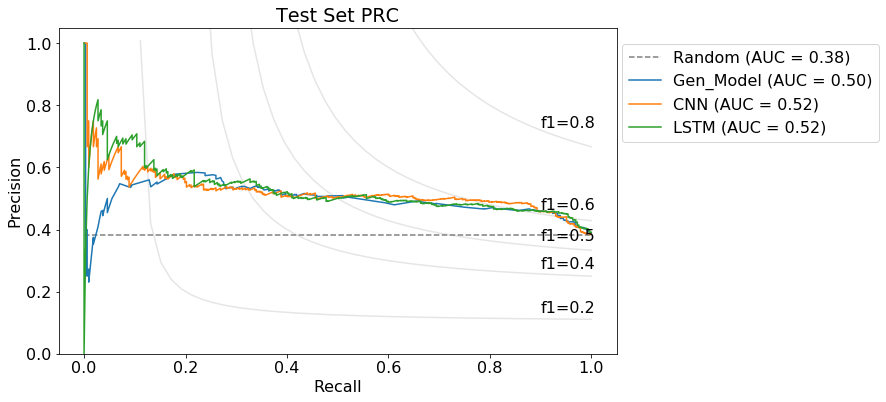

In [154]:
final_test_df = pd.DataFrame(
        pd.np.stack([
            gen_model_test_df["gen_model"].values,
            best_cnn_test,
            best_lstm_test
        ],
            axis=1), 
        columns=["Gen_Model", "CNN", "LSTM"]
    )
aucs=plot_curve(
    final_test_df,
    test_Y.numpy(), 
    plot_title="Test Set PRC", 
    metric="PR", 
    model_type="curve"
)

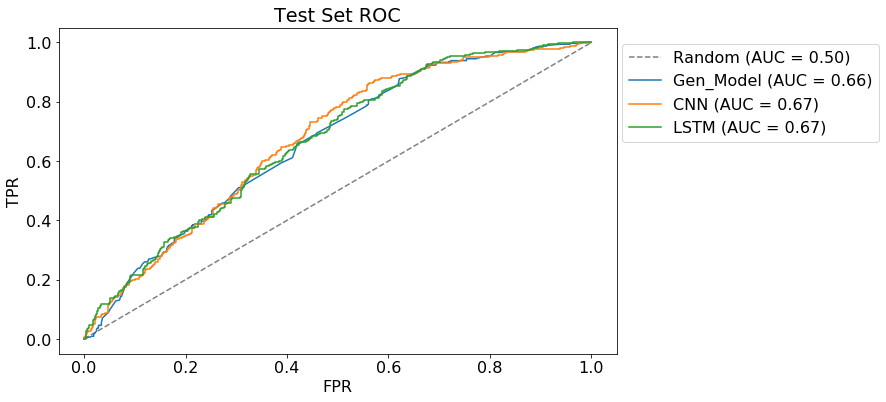

In [155]:
aucs=plot_curve(
    final_test_df,
    test_Y.numpy(), 
    plot_title="Test Set ROC", 
    metric="ROC", 
    model_type="curve"
)

In [138]:
get_auc_significant_stats(
     test_data
    .query("sen_length < @cutoff")
    .merge(candidate_dfs['test']),
    aucs
)

mu: 86328.000000, sigma: 3509.434142


,auroc,u,z_u,p_value
Gen_Model,0.663415,114542.5,8.039615,4.506052e-16
CNN (7777 l2:2),0.674324,116426.0,8.576311,4.898205e-18
LSTM (250 l2:0.25),0.669852,115654.0,8.356333,3.234898e-17


In [139]:
error_output_df = (
    candidate_dfs['dev'][[
    'candidate_id', 'disease', 
    'gene', 'doid_id', 
    'entrez_gene_id', 'sentence_id', 
    'sentence', 'curated_dsh'
    ]]
    .merge(gen_model_dev_df[['gen_model', 'candidate_id']], on="candidate_id")
    .sort_values("candidate_id")
)

error_output_df['lstm'] = best_lstm_dev
error_output_df['cnn'] = best_cnn_dev
error_output_df.head(2)

,candidate_id,disease,gene,doid_id,entrez_gene_id,sentence_id,sentence,curated_dsh,gen_model,lstm,cnn
0,177856,systemic lupus erythematosus,thrombin,DOID:9074,2147,2106040,it is thought to reflect increased ~~[[2 throm...,1.0,0.184703,0.126485,0.169539
1,235056,major depression,5HT1A),DOID:1595,3350,2946297,"gepirone , a selective serotonin ( ~~[[2 5ht1a...",1.0,0.124327,0.104590,0.120518


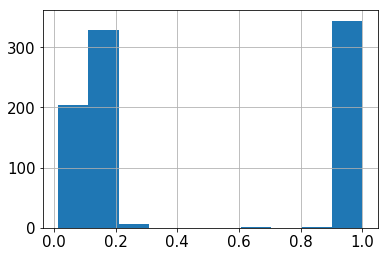

In [152]:
error_output_df["gen_model"].hist()

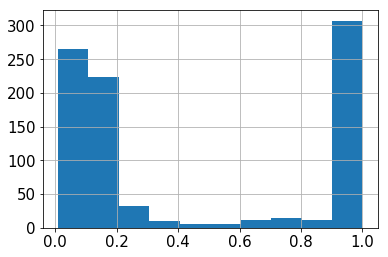

In [153]:
error_output_df["lstm"].hist()

In [141]:
spreadsheet_name = "data/sentence_dev_error_analysis.xlsx"
writer = pd.ExcelWriter(spreadsheet_name)

(
    error_output_df
    .to_excel(writer, sheet_name='sentences', index=False)
)

if writer.engine == 'xlsxwriter':
    for sheet in writer.sheets.values():
        sheet.freeze_panes(1, 0)

writer.close()